In [37]:
#@title Install Required Libraries
%%capture
!pip install pygad
!pip install gradient_free_optimizers
!pip install line_profiler
!pip install shgo
!pip install fpdf matplotlib

%load_ext line_profiler
import numpy as np
from scipy.spatial import HalfspaceIntersection, ConvexHull
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# The link below can be referred for more information about profiling the code line by line
# https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.07-Timing-and-Profiling.ipynb#scrollTo=lRMD7pePczP1
# https://stackoverflow.com/questions/70303330/how-can-i-do-lprun-work-on-nested-function-in-python

# TODO
- [x] Correct the function to show all normals
- [x] Construct optimal feedback in its functional form (in terms of x and y)
- [ ] Dictionary creation --> start from constants and extend
- [ ] Hyperparameter tuning --> Epsilon, Genetic Algorithm Parameters, Max Norm?
- [ ] Plotting of trajectories --> How do different trajectories vary with changing Epsilon
- [x] Metric that can be used --> Constraint violations, Maximum Dot Product
- [ ] Robustness, How does the algorithm work under a noisy setting?
- [x] PART2: Try out all the things with a different domain
- [x] f(x) + g(x)u(x) not zero

POLYGONS
- [ 1 ] Heptagon
- [ 2 ] Star
- [ 3 ] Donut Square
- [ 4 ] Disconnected Domain

FUNCTIONS
- [ 1 ] Radial outward
- [ 2 ] Circulant
- [ 3 ] Sum of 1 and 2
- [ 4 ] Noisy function

G(X)
- [ 1 ] Nothing
- [ 2 ] Rotation Matrix
- [ 3 ] Some function of x

TABLES
- [ 1 ] On x-axis will be different polygons, On y-axis will be different epsilon, values will be SCV
- [ 2 ] On x-axis will be different polygons, On y-axis will be different dictionaries in an incremental fashion, values will be SCV
- [ 3 ] On x-axis will be different polygons, On y-axis will be different dictionaries in an incremental fashion, values will be Runtimes

In [38]:
#@title NonConvexPolytope Class
class NonConvexPolytope2D():
  def __init__(self, vertices):
    # Vertices should be defined as a list of points --> which will be p1, p2, ... , pn
    # vertices is a list of arrays
    # It is important to define these in an anticlockwise manner --> since the outward vector normal calculation will follow from that
    self.vertices = vertices

  def set_edge_list(self):
    edge_list = []
    for i in range(len(self.vertices) - 1):
      edge_list.append([self.vertices[i], self.vertices[i + 1]])
    edge_list.append([self.vertices[-1], self.vertices[0]])
    self.edge_list = edge_list

  def set_normals_to_edges(self):
    normals_list = []
    for i in range(len(self.edge_list)):
      p1 = self.edge_list[i][0]
      p2 = self.edge_list[i][1]
      along_vec = p2 - p1
      unit_along_vec = along_vec/np.linalg.norm(along_vec)
      rot = np.array([[0, 1], [-1, 0]])
      normal_to_edge = np.dot(rot, unit_along_vec)
      normals_list.append(normal_to_edge)
    self.normal_list = normals_list

  def compute_static_mesh(self, N = 100):
      edges = self.edge_list
      num_edges = len(edges)
      points_per_edge = int(N/num_edges)
      list_points = []
      mesh_normals = []
      for i in range(len(edges)):
        a, b = edges[i]
        point_lambdas = np.arange(1, points_per_edge + 1)/points_per_edge
        for t in point_lambdas:
          point = t*a + (1 - t)*b
          list_points.append(point)
          mesh_normals.append(self.normal_list[i])
      self.static_mesh = np.array(list_points)
      self.mesh_normals = np.array(mesh_normals)

  def genome_to_points(self, genome):
        points = []
        normals = []
        for i in range(0, len(genome), 2):
            #edge_idx = int(genome[i])%len(self.polytope._edges)
            edge_idx = int(np.clip(genome[i], 0, len(self.edge_list) - 1))
            t = np.clip(genome[i+1], 0.0, 1.0)
            a, b = self.edge_list[edge_idx]
            pt = (1 - t) * a + t * b
            points.append(pt)
            normals.append(self.normal_list[edge_idx])
        return np.array(points), np.array(normals)


  def compute_metric_mesh(self, N = 1000):
      edges = self.edge_list
      num_edges = len(edges)
      points_per_edge = int(N/num_edges)
      list_points = []
      mesh_normals = []
      for i in range(len(edges)):
        a, b = edges[i]
        point_lambdas = np.arange(1, points_per_edge + 1)/points_per_edge
        for t in point_lambdas:
          point = t*a + (1 - t)*b
          list_points.append(point)
          mesh_normals.append(self.normal_list[i])
      self.metric_mesh = np.array(list_points)
      self.metric_normals = np.array(mesh_normals)



In [39]:
#@title f(x),g(x),u(x)
def f_of_x(x):
  #Input: \x in R^v
  #Output: f(\x) in R^v

  f  = np.zeros(x.shape[0])
  f[0] = -x[1] + 0.5*x[0]
  f[1] = x[0] + 0.5*x[1]
  return f

def g_of_x(x):
  #Input: \x in R^v
  #output: g(x) in R^(vxm)
  theta = np.pi/4
  g = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
  return g

def u_of_x(x, eta, lambdified_dict):
  #Input: \x in R^v, \lambdified_dict,
  #Output: u(x) in R^m
  u_x = np.zeros(x.shape[0])
  for i in range(0, eta.shape[0]):
    u_x += eta[i]*lambdified_dict[i](*x)
  return u_x

def diff_eqn(x, eta, lambdified_dict):
  #Input: A point \x, \grad_x --> for the stochastic case
  #Do we need max_noise? --> should it not be a constant? --> maybe in an OOP approach it wont be needed.
  #Output: \x_dot = f(x) + g(x)u(x) + w(x)
  #What we know --> f(.), g(.), w(.)
  #Note that here \x is in R^v
  #\u is in R^m
  #and therefore g(.) is in R^(v x m)
  #Right now just assume a zero-noise version --> w = 0
  #Further, we are removing k from the version since we just want to do this with a single point x
  # Initialize everything --> Even this code can just be an external pull to a function f, which is what we shall do
  # Also, note that in the arbitrary case, g becomes a function of x --> again use a function approach
  # the same can be done for u(x)
  f = f_of_x(x)
  g = g_of_x(x)
  u = u_of_x(x, eta, lambdified_dict)
  g_times_u = np.dot(g, u)
  return f + g_times_u

In [40]:
#@title Inner Optimization
import numpy as np
from scipy.optimize import minimize
import time
from shgo import shgo
import random
#import gradient_free_optimizers as gradfree

def inner_minimization(x_array,  grad_x_list, lambdified_dict, static_mesh, mesh_normals, EPSILON_HAMILTONIAN):


    #Basically, we want to solve the inner minimization problem which says
    #Given points (x_1, x_2, x_3, ... , x_n) --> first set up a constraint corresponding to each x_i
    #The feedback function should be such that all the n constraints need to be satisfied.
    #In addition to this, in order to ensure convexity and convergence, we add an objective function to the mix.
    #The eta are only called into the inner minimization since they are the ones over which we actually minimize.
    #We are not specifying any bound on eta --> let them go from (-inf, inf)
    #For now, we are writing the code assuming that there is only one boundary normal at every point.
    #Later on we can scale it to cones.
    MAX_VAL =  10e8

    # def objective_function(eta):
    #   sum = 0
    #   for i in range(static_mesh.shape[0]):
    #     x_dot_noisy = diff_eqn(static_mesh[i], eta, lambdified_dict)
    #     for basis_func in mesh_normals[i]:
    #       dot_product = np.dot(basis_func, x_dot_noisy)
    #       sum += dot_product
    #   return sum
    def objective_function(eta):
      sum = 0
      for i in range(static_mesh.shape[0]):
        x_dot_noisy = diff_eqn(static_mesh[i], eta, lambdified_dict)
        dot_product = np.dot(mesh_normals[i], x_dot_noisy)
        sum += dot_product
      return sum

    # def objective_function(eta):
    #   sum = 0
    #   for i in range(0, len(eta)):
    #     sum += np.abs(eta[i]**2)
    #   return sum

    def bounds_function(i):
        return (-np.inf, np.inf)

    # def constraint_function1(eta, k):
    #   x_dot_noisy = diff_eqn(x_array[k], eta, lambdified_dict)
    #   # This should never be empty
    #   # If it is empty constraint will anyway get satisfied
    #   max_dot_product = -1e8
    #   for basis_func in grad_x_list[k]:
    #     #print(f"Basis function is {basis_func}")
    #     dot_product = np.dot(basis_func, x_dot_noisy)
    #     if(dot_product > max_dot_product):
    #       max_dot_product = dot_product
    #   return (max_dot_product + EPSILON_HAMILTONIAN)

    def constraint_function1(eta, k):
      x_dot_noisy = diff_eqn(x_array[k], eta, lambdified_dict)
      # This should never be empty
      # If it is empty constraint will anyway get satisfied
      max_dot_product = np.dot(grad_x_list[k], x_dot_noisy)
      return (max_dot_product + EPSILON_HAMILTONIAN)

    def constraint_function2(eta,k):
      norm_eta = np.linalg.norm(eta)
      is_allowed = (norm_eta-2)
      return is_allowed

    bounds = [bounds_function(i) for i in range(0, len(lambdified_dict))] #minimise

    constraint_functions1  = [lambda eta, k=k: -constraint_function1(eta, k) for k in range(x_array.shape[0])]
    constraint_functions2  = [lambda eta, k=k: -constraint_function2(eta, k) for k in range(x_array.shape[0])]

    merged_constraint_functions = constraint_functions1 + constraint_functions2

    constraints = [{'type': 'ineq', 'fun': func} for func in merged_constraint_functions]

    initial_guess = [1]*len(lambdified_dict)
    for k in range(x_array.shape[0]):
      val = constraint_function1(np.zeros(len(lambdified_dict)), k)
      # print(f"Constraint1 value at k={k} with zero eta: {val}")


    #Here, we could actually compute the center of whatever convex body we are choosing and then try\
    #and make it point towards the center of that body ---> Sounds like something that will optimize it quite well
    #initial_guess = [c1/a1**2, c2/a2**2, -1/a1**2,0,0,-1/a2**2,0,0,0,0]
    # initial_guess = [1, 1, -1,0,0,-1,0,0,0,0]

    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints, \
                      options={'disp': False})
    #print(result)
    end_time_in = time.time()
    if result.success == True:
      return result.fun, result.x
    elif result.success == False:
      print("Printing result ====================================================================================")
      print(result)
      print(f"Failed to solve inner optimization. Error message: f{result.message}")
      return MAX_VAL, result.x

In [41]:
#@title Polytope Sampler GA

# vertices = star
# ncp = NonConvexPolytope2D(vertices)
# ncp.set_edge_list()
# ncp.set_normals_to_edges()
# ncp.compute_static_mesh(100)
# mesh = ncp.static_mesh
# normals = ncp.mesh_normals

import pygad
import numpy as np

class PolytopeSamplerGA:
    def __init__(self, vertices, num_points, lambdified_dict, EPSILON_HAMILTONIAN = 1e-5):
        self.ncp = NonConvexPolytope2D(vertices)
        self.num_points = num_points
        self.lambdified_dict = lambdified_dict
        self.ncp.set_edge_list()
        self.ncp.set_normals_to_edges()
        self.ncp.compute_static_mesh(100)
        self.ncp.compute_metric_mesh(1000)
        self.fitness_over_time = []
        self.static_mesh  = self.ncp.static_mesh
        self.mesh_normals = self.ncp.mesh_normals
        self.EPSILON_HAMILTONIAN = EPSILON_HAMILTONIAN

    def fitness_func(self, ga_instance, solution, solution_idx):
        x_array, grad_x_list = self.ncp.genome_to_points(solution)
        #print(f"Solution at {solution_idx} is {solution}")
        try:
            fitness, _ = inner_minimization(x_array, grad_x_list, self.lambdified_dict, self.static_mesh, self.mesh_normals, self.EPSILON_HAMILTONIAN)
        except Exception as e:
            print(f"Exception in inner optimization: {e}")
            fitness = 1e8
        return fitness  # pygad maximizes

    def on_gen(self, ga_instance):
        self.fitness_over_time.append(ga_instance.best_solution()[1])

    def run(self, num_generations=30, sol_per_pop=10):
        num_genes = self.num_points * 2  # (ai, bi) for each point
        gene_space = []
        gene_type = []
        for i in range(self.num_points):
            gene_space.append({'low': 0, 'high': len(self.ncp.edge_list)})  # ai
            gene_space.append({'low': 0.0, 'high': 1.0})  # bi
            gene_type.append(int)
            gene_type.append(float)


        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=2,
            fitness_func=self.fitness_func,
            sol_per_pop=sol_per_pop,
            num_genes=num_genes,
            gene_space=gene_space,
            parent_selection_type="rws",
            keep_parents=0,
            crossover_type="single_point",
            mutation_type="random",
            mutation_percent_genes=20,
            gene_type = gene_type,
            on_generation = self.on_gen
        )

        ga_instance.run()

        solution, fitness, _ = ga_instance.best_solution()

        return solution, -fitness  # converting back to minimization value


In [42]:
#@title Plot Vector Field and Print Optimal Feedback
def plot_vector_field_and_print_optimal_feedback(sampler, solution, raw_dict, lambdified_dict):
    ncp = sampler.ncp
    x_sol, n_sol = ncp.genome_to_points(solution)
    _, eta_opt = inner_minimization(x_sol, n_sol, lambdified_dict, ncp.static_mesh, ncp.mesh_normals, sampler.EPSILON_HAMILTONIAN)
    opt_feedback = compute_optimal_symbolic_feedback(eta_opt, raw_dict)

    mesh_f = []
    mesh_fgu = []
    for i in range(ncp.static_mesh.shape[0]):
        raw_f = f_of_x(ncp.static_mesh[i])
        ripe_f = diff_eqn(ncp.static_mesh[i], eta_opt, lambdified_dict)
        mesh_f.append(raw_f)
        mesh_fgu.append(ripe_f)

    mesh_f = np.array(mesh_f)
    mesh_fgu = np.array(mesh_fgu)

    # --- Create 2x2 subplot grid
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # --- Plot 1: Raw vector field f(x)
    axs[0, 0].scatter(ncp.static_mesh[:, 0], ncp.static_mesh[:, 1], c='green', label='Mesh')
    axs[0, 0].quiver(ncp.static_mesh[:, 0], ncp.static_mesh[:, 1], mesh_f[:, 0], mesh_f[:, 1])
    axs[0, 0].set_title("Raw vector field f(x)")
    axs[0, 0].axis('equal')
    axs[0, 0].legend()

    # --- Plot 2: Processed vector field f(x) - ∇gᵗ η
    axs[0, 1].scatter(ncp.static_mesh[:, 0], ncp.static_mesh[:, 1], c='green', label='Mesh')
    axs[0, 1].quiver(ncp.static_mesh[:, 0], ncp.static_mesh[:, 1], mesh_fgu[:, 0], mesh_fgu[:, 1])
    axs[0, 1].set_title("Controlled vector field f(x)  + g(x)u(x)")
    axs[0, 1].axis('equal')
    axs[0, 1].legend()

    # --- Plot 3: Both fields overlayed
    axs[1, 0].scatter(ncp.static_mesh[:, 0], ncp.static_mesh[:, 1], c='green', label='Mesh')
    axs[1, 0].quiver(ncp.static_mesh[:, 0], ncp.static_mesh[:, 1], mesh_f[:, 0], mesh_f[:, 1], color='blue', label='f(x)')
    axs[1, 0].quiver(ncp.static_mesh[:, 0], ncp.static_mesh[:, 1], mesh_fgu[:, 0], mesh_fgu[:, 1], color='red', label='f(x)  + g(x)u(x)')
    axs[1, 0].set_title("Overlay: f(x) (blue) and projected (red)")
    axs[1, 0].axis('equal')
    axs[1, 0].legend()

    # --- Plot 4: Genetic Algorithm Fitness
    axs[1, 1].plot(sampler.fitness_over_time, marker='o')
    axs[1, 1].set_title("Fitness Over Generations")
    axs[1, 1].set_xlabel("Generation")
    axs[1, 1].set_ylabel("Best Fitness")
    axs[1, 1].grid(True)

    plt.tight_layout()
    #plt.show()
    return fig, opt_feedback


def compute_optimal_symbolic_feedback(optimal_eta, raw_dict):
    optimal_feedback = 0*raw_dict[0]
    for i in range(len(optimal_eta)):
        optimal_feedback += optimal_eta[i]*raw_dict[i]
    return optimal_feedback



In [43]:
#@title Trajectory Plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ========== SYSTEM DEFINITIONS ========== #


# ========== VISUALIZATION HELPERS ========== #
def plot_nonconvex_boundary(ax, ncp):
    ax.scatter(ncp.static_mesh[:, 0], ncp.static_mesh[:, 1], c='green', label='Mesh')

def plot_vector_field_background(ax, eta, lambdified_dict, domain, density=25, scale=0.15):
    x_vals = np.linspace(domain[0], domain[1], density)
    y_vals = np.linspace(domain[2], domain[3], density)
    X, Y = np.meshgrid(x_vals, y_vals)
    U, V = np.zeros_like(X), np.zeros_like(Y)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])
            vec = diff_eqn(x, eta, lambdified_dict)
            norm = np.linalg.norm(vec)
            if norm != 0:
                vec = vec * scale / norm  # scale relative to domain
            U[i, j], V[i, j] = vec

    ax.quiver(X, Y, U, V, color='gray', alpha=0.4, scale=1, scale_units='xy')

def compute_trajectory(x0, eta, lambdified_dict, t_span, dt):
    def dyn(t, x): return diff_eqn(x, eta, lambdified_dict)
    sol = solve_ivp(dyn, t_span, x0, t_eval=np.arange(t_span[0], t_span[1], dt), method='RK45')
    return sol.y.T

# ========== MAIN PLOTTING FUNCTION ========== #
def plot_trajectories_with_vector_field(sampler, domain, initial_conditions, eta, lambdified_dict, t_span=(0, 5), dt=0.01):
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    axes = axes.flatten()

    for i, x0 in enumerate(initial_conditions):
        ax = axes[i]
        plot_nonconvex_boundary(ax, sampler.ncp)
        plot_vector_field_background(ax, eta, lambdified_dict, domain)

        # Uncontrolled trajectory
        zero_eta = np.zeros_like(eta)
        traj_unctrl = compute_trajectory(x0, zero_eta, lambdified_dict, t_span, dt)
        ax.plot(x0[0], x0[1], '^', ms = 10, mfc = 'black',  mec = 'black', label ='Start Point')
        ax.plot(traj_unctrl[:, 0], traj_unctrl[:, 1], 'r-', label='Uncontrolled')

        # Controlled trajectory
        traj_ctrl = compute_trajectory(x0, eta, lambdified_dict, t_span, dt)
        ax.plot(traj_ctrl[:, 0], traj_ctrl[:, 1], 'b-', label='Controlled')

        ax.set_xlim(domain[0], domain[1])
        ax.set_ylim(domain[2], domain[3])
        ax.set_title(f"Trajectories from {x0}")
        ax.set_aspect('equal')
        ax.legend()

    plt.tight_layout()
    #plt.show()
    return fig


In [44]:
#@title Metric Definition
def compute_constraint_violation_metric(eta, static_mesh, mesh_normals, lambdified_dict):
    """
    Computes a constraint violation metric based on cosine similarity between
    the vector field at boundary points and their outward normals.

    Parameters:
    - eta: Control variable.
    - static_mesh: (N, d) array of mesh points along the boundary.
    - mesh_normals: (N, d) array of corresponding outward normals at each mesh point.
    - lambdified_dict: Dictionary of symbolic expressions.
    - diff_eqn: Function f(x) + g(x)u(x) evaluating dynamics under control.

    Returns:
    - metric: Sum of max(cos(theta), 0) over all mesh points, where
              theta is the angle between dynamics and outward normal.
    """
    total_violation = 0.0
    for i in range(static_mesh.shape[0]):
        x = static_mesh[i]
        n = mesh_normals[i]
        x_dot = diff_eqn(x, eta, lambdified_dict)

        norm_x_dot = np.linalg.norm(x_dot)
        norm_n = np.linalg.norm(n)

        if norm_x_dot == 0 or norm_n == 0:
            cosine_sim = 0.0  # Treat as no violation if either vector is degenerate
        else:
            cosine_sim = np.dot(n, x_dot) / (norm_n * norm_x_dot)

        total_violation += max(cosine_sim, 0.0)

    return total_violation/static_mesh.shape[0]


In [50]:
#@title Defining an automated Main Loop class
import numpy as np
from sympy import Array, symbols, lambdify
import os

class MainLoop:
  def __init__(self, fg_name, domain_name, dict_name, vertices, initial_conditions, axlen,  basis_dict, EPSILON_HAMILTONIAN, num_points, num_generations, sol_per_pop, t_span):
    self.fg_name = fg_name
    self.domain_name = domain_name
    self.dict_name = dict_name
    self.vertices = vertices
    self.initial_conditions = initial_conditions
    self.basis_dict = basis_dict
    self.EPSILON_HAMILTONIAN = EPSILON_HAMILTONIAN
    self.num_points = num_points
    self.num_generations = num_generations
    self.sol_per_pop = sol_per_pop
    self.axlen = axlen
    self.t_span = t_span
    self.create_dictionaries()
    self.run_main()

  def create_dictionaries(self):
    x1, x2 = symbols('x1 x2')
    self.raw_dict = self.basis_dict
    self.lambdified_dict = {}
    for key in self.raw_dict.keys():
      self.lambdified_dict[key] = lambdify([x1, x2], self.raw_dict[key], 'numpy')


  def run_main(self):
    start_time = time.time()
    sampler = PolytopeSamplerGA(self.vertices, self.num_points, self.lambdified_dict, self.EPSILON_HAMILTONIAN)
    solution, best_val = sampler.run(num_generations=self.num_generations, sol_per_pop=self.sol_per_pop)
    end_time = time.time()
    x_sol, n_sol = sampler.ncp.genome_to_points(solution)
    _, eta_opt = inner_minimization(x_sol, n_sol, self.lambdified_dict, sampler.ncp.static_mesh, sampler.ncp.mesh_normals, sampler.EPSILON_HAMILTONIAN)
    eta_subopt = np.array([0 for i in range(len(eta_opt))])
    domain = [-self.axlen,  self.axlen, -self.axlen,  self.axlen]
    vec_field, opt_sym_feedback = plot_vector_field_and_print_optimal_feedback(sampler, solution, self.raw_dict, self.lambdified_dict)
    violation_score = compute_constraint_violation_metric(eta_opt, sampler.ncp.metric_mesh, sampler.ncp.metric_normals, lambdified_dict)
    control_vs_not_traj = plot_trajectories_with_vector_field(sampler, domain, self.initial_conditions, eta_opt, self.lambdified_dict, self.t_span)
    no_control_traj = plot_trajectories_with_vector_field(sampler, domain, self.initial_conditions, eta_subopt, self.lambdified_dict, self.t_span)


    dir_name = f"{self.domain_name}_{self.fg_name}_{self.dict_name}_{str(self.EPSILON_HAMILTONIAN)}"
    os.mkdir(dir_name)
    with open(dir_name + '/' + 'info.txt', 'w') as info:
      info.write(f"Domain: {self.domain_name}\n")
      info.write(f"Function: {self.fg_name}\n")
      info.write(f"Dictionary: {self.dict_name}\n")
      info.write(f"Epsilon: {self.EPSILON_HAMILTONIAN}\n")
      info.write("==========================================================================================\n")
      info.write(f"Optimal Symbolic Feedback: \n {opt_sym_feedback[0]}\n {opt_sym_feedback[1]}\n")
      info.write(f"Runtime: {end_time - start_time} seconds \n")
      info.write(f"Constraint Violation Score: {violation_score}\n")
    vec_field.savefig(dir_name + '/' + 'vec_field_' + dir_name + '.jpg')
    control_vs_not_traj.savefig(dir_name + '/' + 'control_traj_' + dir_name + '.jpg')
    no_control_traj.savefig(dir_name + '/' + 'uncontrol_traj_' + dir_name + '.jpg')


In [46]:
#@title Running main loop
import numpy as np
from sympy import Array, symbols, lambdify


#1. STAR
####===============================####
r1 = 1
r2 = 2
theta1 = np.pi/6
theta2 = np.pi/3
star = []
for i in range(0, 6):
  star.append(np.array([r1*np.cos(theta1), r1*np.sin(theta1)]))
  star.append(np.array([r2*np.cos(theta2), r2*np.sin(theta2)]))
  theta1 += np.pi/3
  theta2 += np.pi/3




#2. C-SHAPE
####===============================####
c_shape = [np.array([2,2]), np.array([2,3]), np.array([-1,3]), np.array([-1,-3]), np.array([2,-3]), np.array([2,-2]), np.array([0,-2]), np.array([0,2])]


vertices = star



###===================================###
#BASIS DICTIONARIES
x1, x2 = symbols('x1 x2')

raw_dict = {
    0:Array([1, 0]), \
    1:Array([0, 1]), \
    2:Array([x1, 0]), \
    3:Array([x2, 0]), \
    4:Array([0, x1]), \
    5:Array([0, x2]), \
}


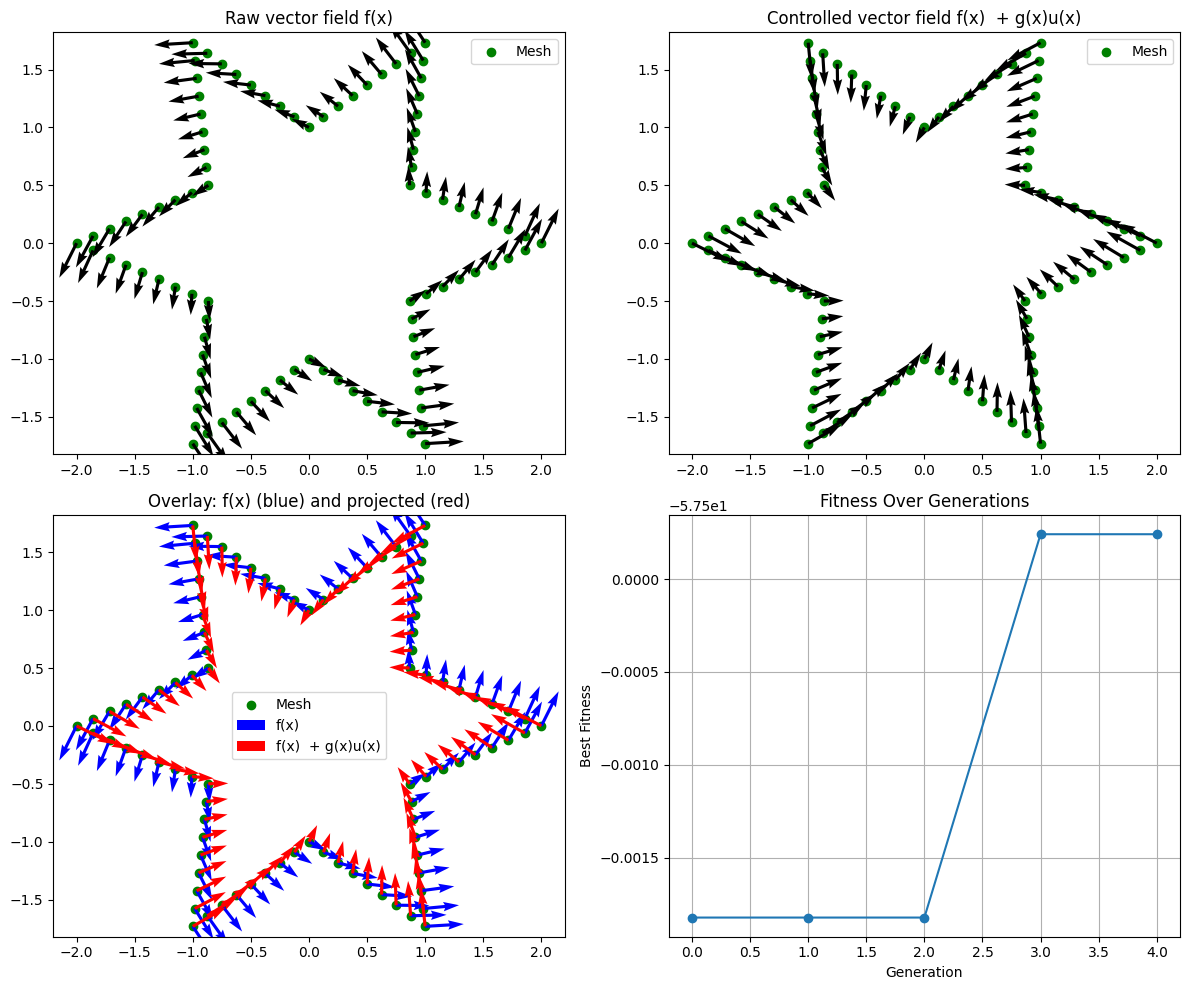

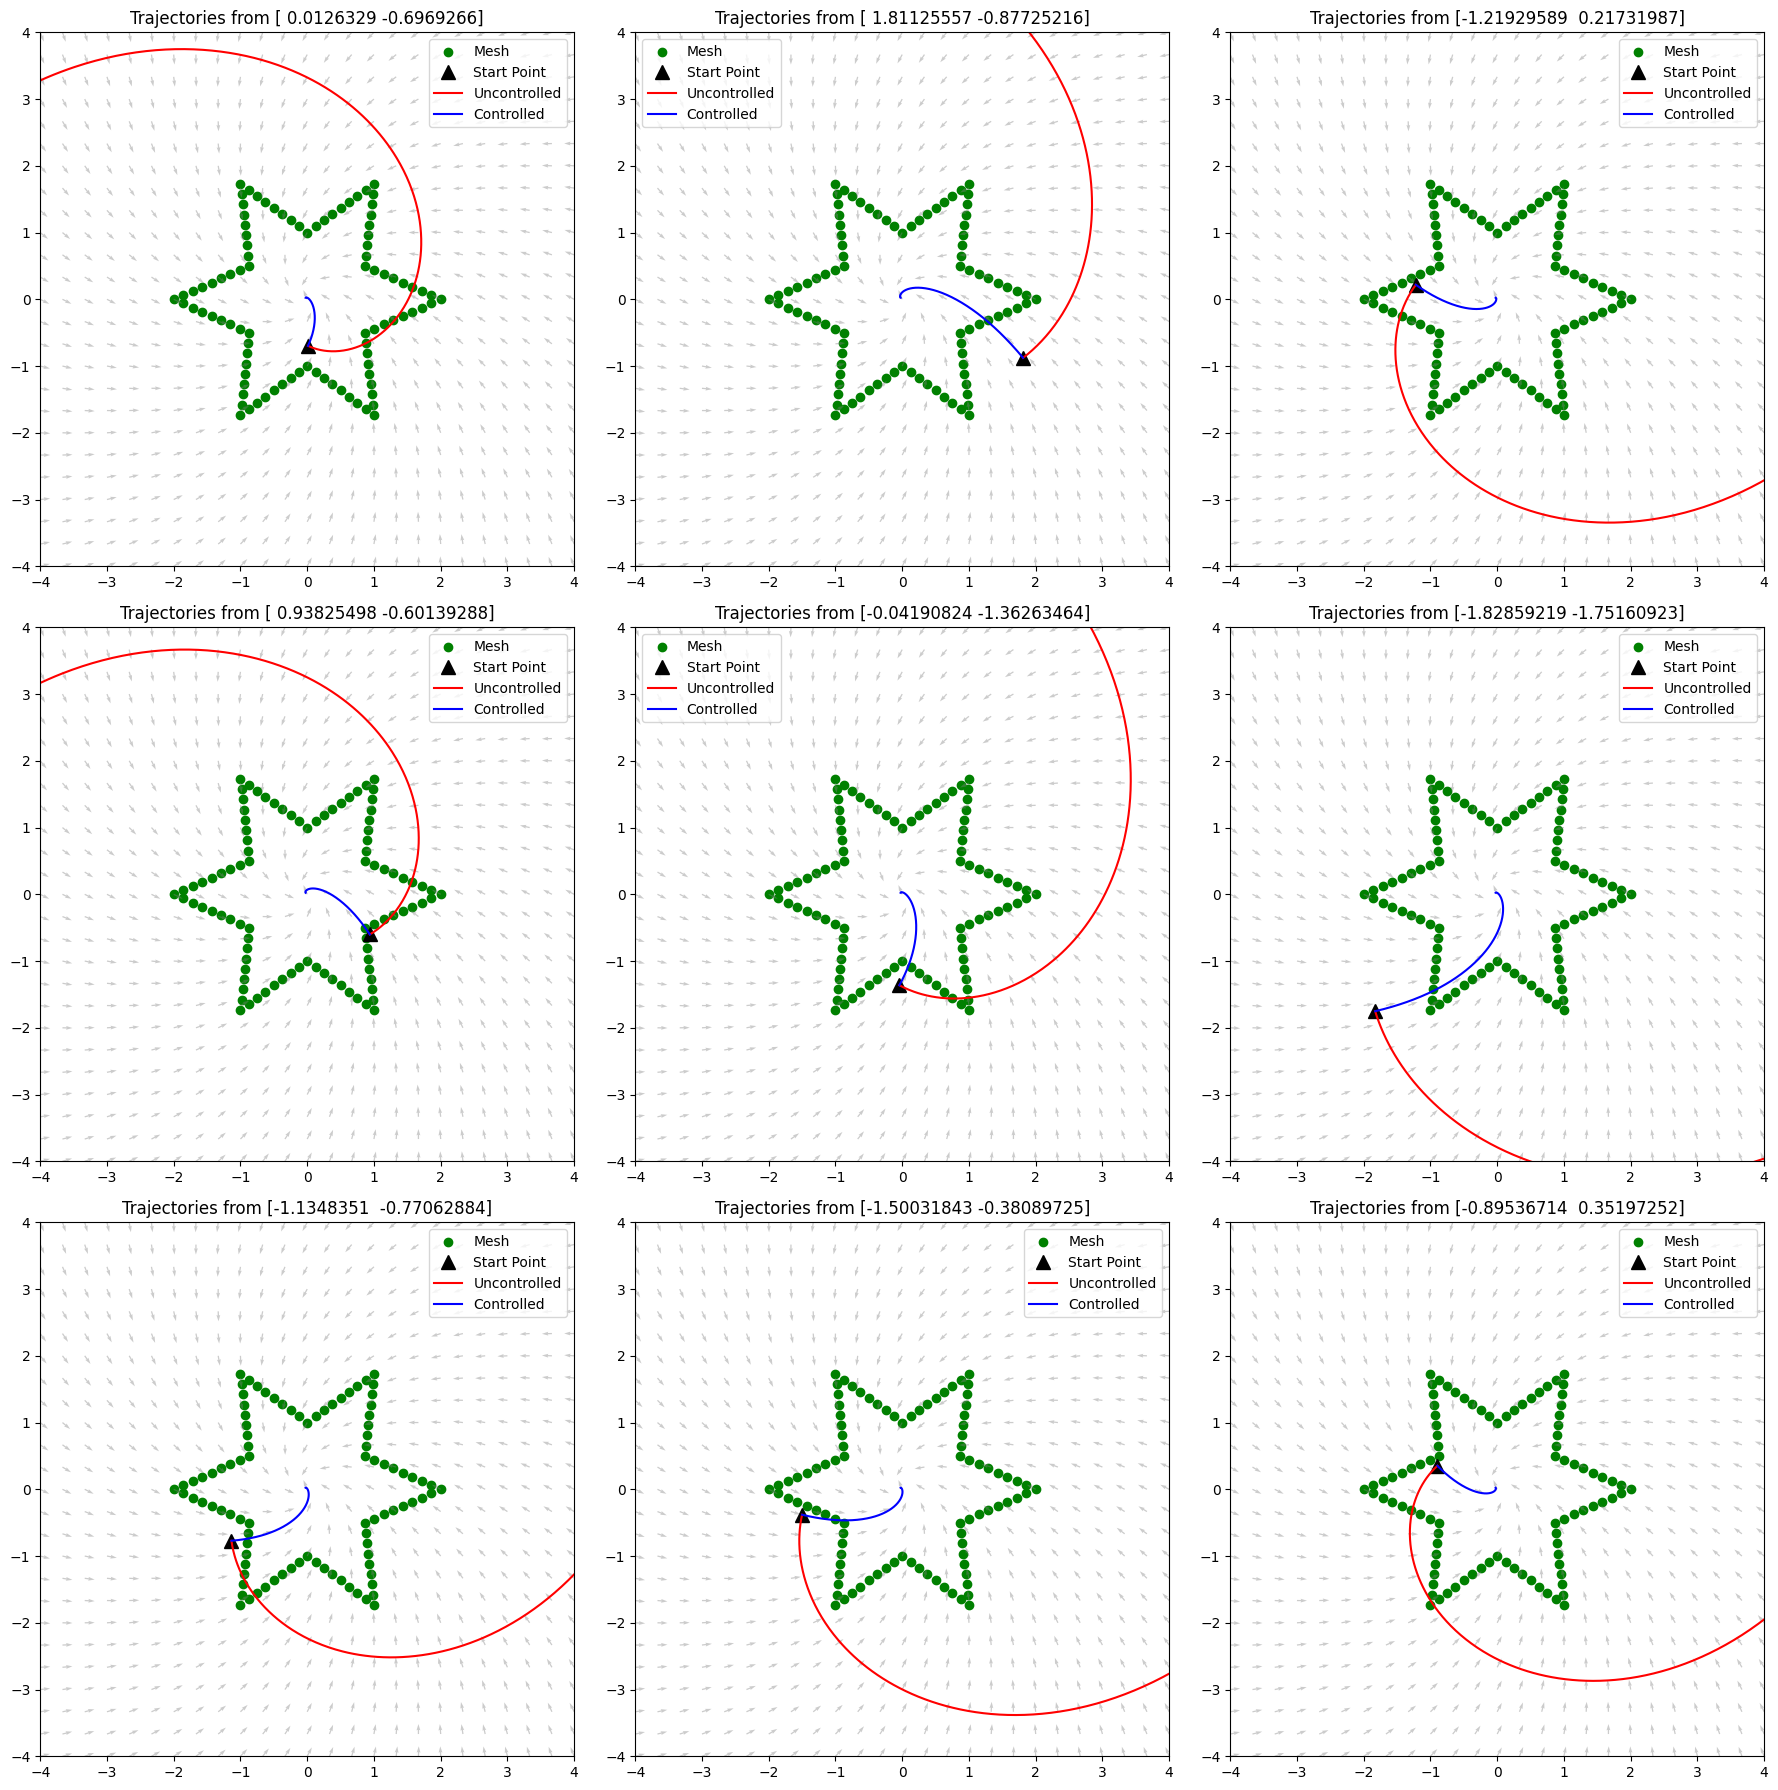

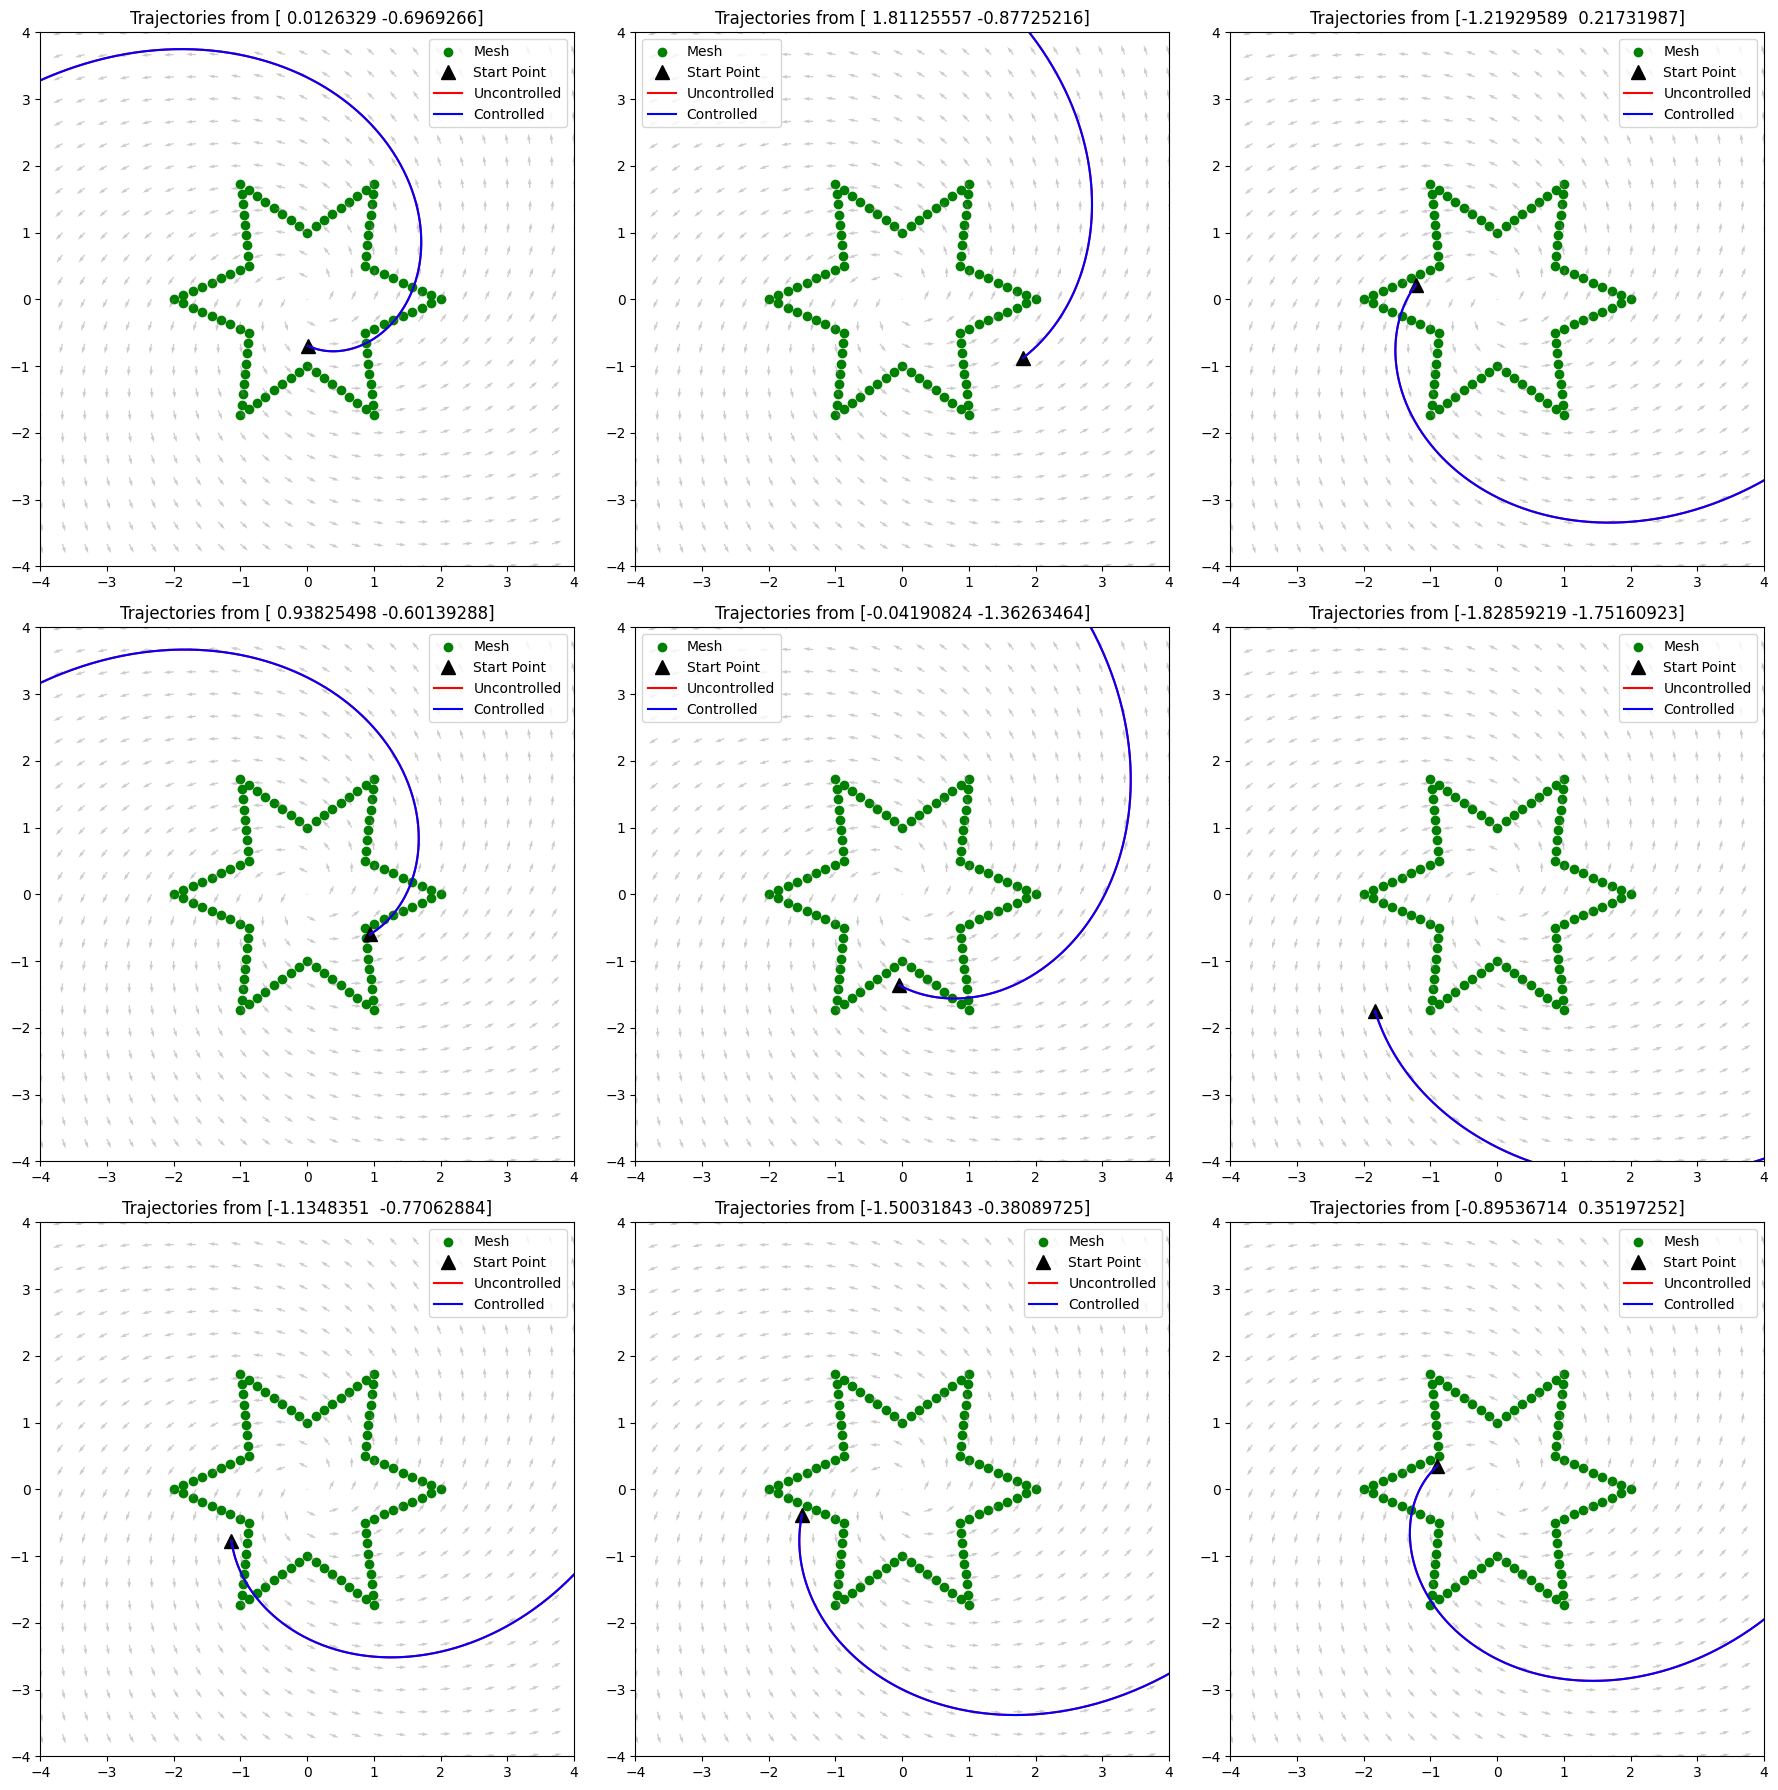

In [49]:
mainloop = MainLoop(fg_name = 'CIRCULANT', domain_name = 'STAR',\
                    dict_name = 'LINEAR', vertices = star, \
                    initial_conditions =[np.array([2*np.random.choice([1, -1])*np.random.random(), 2*np.random.choice([1, -1])*np.random.random()]) for i in range(3) for j in range(3)] , \
                    axlen = 4,  basis_dict = raw_dict,  EPSILON_HAMILTONIAN = 1e-3, \
                    num_points = 10, num_generations = 5, sol_per_pop = 4,
                    t_span = (0, 10))